We first load a time series dataset from a file:

In [4]:
import pandas as pd

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())
print('\n Data Types:')
print(data.dtypes)

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

 Data Types:
#Passengers    int64
dtype: object


We see that we have two different columns: 

1) Month, which is a timestamp of the month at which the second column was measured --> This is the time axis

2) Passengers, which is the amplitude of each sample in the time series

The time difference between samples is one month, so we would expect that a time horizon of h=1 would correspond to a forecasting one month ahead in time.

Before modeling, we will proceed with a first inspection of the time series. Let's plot it:

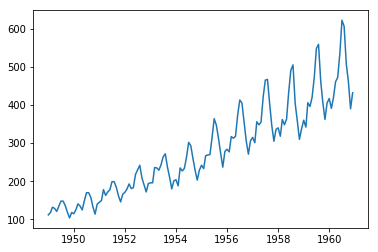

In [5]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(data)
plt.show()

Wow, a clear rising trend with a clear seasonality pattern. This could have been intuitive, as everyone of us suspects that the number of passengers in a given airline increases on a yearly basis, and has some periods over a year, specially in summertime, holidays and the like.

Let us verify whether the time series is stationary. Clearly it is not, but let's look for a hypothesis testing tool that helps us verify the stationarity of the series. The null hypothesis of the Augmented Dickey–Fuller (ADF) test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

Let's check it:

p-value:  0.9918802434376409


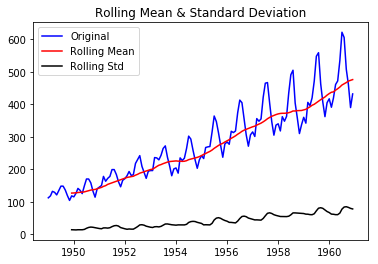

In [21]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data['#Passengers'])
print('p-value: ',dftest[1])

rolmean = data['#Passengers'].rolling(12).mean()
rolstd = data['#Passengers'].rolling(12).std()

plt.plot(data['#Passengers'], color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show()

So definitely our time series is strongly non-stationary. We will now proceed by removing the trend so as to apply models suited for stationary data:

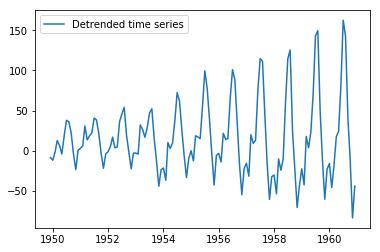

p-value:  0.02210413947387874


In [28]:
ts_notrend = data['#Passengers'] - rolmean
plt.plot(ts_notrend,label='Detrended time series')
plt.legend(loc='best')
plt.show()

ts_notrend.dropna(inplace=True)
dftest = adfuller(ts_notrend)
print('p-value: ',dftest[1])

Two things worth to be mentioned at this point:

1) We do not care about increasing variance. We can fix this by taking the logarithm of data.

2) It seems that we are in the good direction in regards to the trend. But we have NaN values... why?

Let's take care of the increasing variance over time:

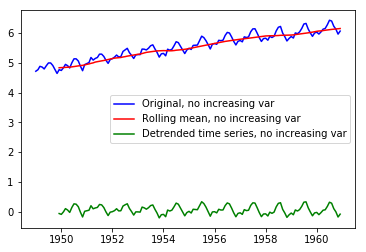

In [29]:
import numpy as np
ts_noincreasingvar = np.log(data)
rolmean_noincreasingvar = ts_noincreasingvar.rolling(12).mean()
plt.plot(ts_noincreasingvar,'b',label='Original, no increasing var')
plt.plot(rolmean_noincreasingvar,'r',label='Rolling mean, no increasing var')
plt.plot(ts_noincreasingvar-rolmean_noincreasingvar,'g',label='Detrended time series, no increasing var')
plt.legend(loc='best')
plt.show()

We now perform the ADF test on the detrended time series with no increasing var, first dropping the NaN values in the series. The reason there are null values is because we take the average of first 12 so 11 values are null:

In [30]:
ts_notrend_noincreasingvar = ts_noincreasingvar-rolmean_noincreasingvar
ts_notrend_noincreasingvar.dropna(inplace=True)
dftest = adfuller(ts_notrend_noincreasingvar['#Passengers'])
print('p-value: ',dftest[1])

p-value:  0.022234630001243844


We could also transform the noincreasingvar time series on stationary by:

1) Differencing – taking the differece with a particular time lag

2) Decomposition – modeling both trend and seasonality and removing them from the model, so that we just need to model the residuals. In essence we have done this so far, but we will see how the whole process can be automated. The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each    period is the returned seasonal component. The trend is estimated by a MA.

Let's see them for completeness:

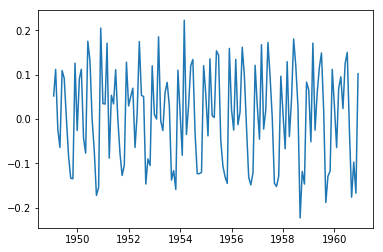

p-value:  0.0711205481508568


In [31]:
ts_log_diff = ts_noincreasingvar - ts_noincreasingvar.shift()
plt.plot(ts_log_diff)
plt.show()
ts_log_diff.dropna(inplace=True)
dftest = adfuller(ts_log_diff['#Passengers'])
print('p-value: ',dftest[1])

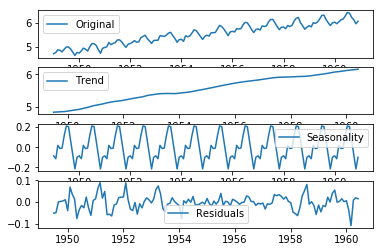

p-value:  2.8850589033233625e-08


In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_noincreasingvar,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_noincreasingvar, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
dftest = adfuller(ts_log_decompose['#Passengers'])
print('p-value: ',dftest[1])


Therefore, we have an stationary time series (residual) on which we can safely apply forecasting methods that do not take into account non-stationarities. However, we will use statistical modelling methods that can accommodate non-stationarities in the data. 

The ARIMA method is suitable for univariate time series with trend and without seasonal components. It resembles a linear regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model:

1) Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5). 

2) Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

3) Number of Differences (d): These are the number of nonseasonal differences.

We can automate the process of selecting which values of p, q and d to select by resorting to cross-validation:

In [33]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.to_numpy()
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
#        print(len(history))
#     calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_ARIMAS(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return (best_cfg, best_score)
 
# evaluate parameters

p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]
warnings.filterwarnings("ignore")
(best_cfg, best_score) = evaluate_ARIMAS(ts_noincreasingvar, p_values, d_values, q_values)
print('Best ARIMA: (p,d,q) = %s with MSE=%.3f' % (best_cfg, best_score))

ARIMA(0, 0, 0) MSE=0.357
ARIMA(0, 0, 1) MSE=0.102
ARIMA(0, 1, 0) MSE=0.013
ARIMA(0, 1, 1) MSE=0.012
ARIMA(0, 1, 2) MSE=0.014
ARIMA(0, 2, 0) MSE=0.019
ARIMA(0, 2, 1) MSE=0.013
ARIMA(1, 0, 0) MSE=0.013
ARIMA(1, 0, 1) MSE=0.012
ARIMA(1, 0, 2) MSE=0.039
ARIMA(1, 1, 0) MSE=0.012
ARIMA(1, 1, 1) MSE=0.012
ARIMA(1, 1, 2) MSE=0.010
ARIMA(1, 2, 0) MSE=0.018
ARIMA(2, 0, 0) MSE=0.012
ARIMA(2, 0, 1) MSE=0.012
ARIMA(2, 1, 0) MSE=0.012
ARIMA(2, 2, 0) MSE=0.017
Best ARIMA: (p,d,q) = (1, 1, 2) with MSE=0.010


We can now plot the forecasts:

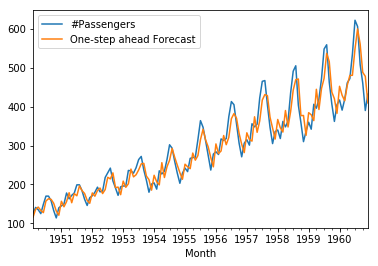

In [35]:
model = ARIMA(ts_noincreasingvar, order=best_cfg)
model_fit_arima = model.fit(disp=0)
predarima = np.exp(model_fit_arima.predict(12+1,dynamic=False,typ='levels')) # 12 for later comparison to SARIMA
ax = np.exp(ts_noincreasingvar[12+1:]).plot(label='observed')
predarima.plot(label='One-step ahead Forecast', ax=ax)
plt.legend(loc='best')
plt.show()

We see that the trend has been captured and modeled, but definitely the forecast is not good (lagging behind as a result of not properly modeling the seasonality).

Can we do it even better? Hopefully, if we resort to forecasting models that account for both seasonality and trend, for instance, a Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA. It is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I), and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

There are three trend elements that require configuration as in the ARIMA model; specifically:

1) p: Trend autoregression order.

2) d: Trend difference order.

3) q: Trend moving average order.

There are five seasonal elements that are not part of ARIMA that must be configured; they are:

1) P: Seasonal autoregressive order.

2) D: Seasonal difference order.

3) Q: Seasonal moving average order.

4) m: The number of time steps for a single seasonal period.

5) Type of trend (no trend, constant trend, linear trend, constant and linear trend)

We can extend the above code to search for the proper configuration of the SARIMA model:

In [37]:
from math import sqrt
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return mean_squared_error(actual, predicted)

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (cfg, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    scores = None
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    [[(0, 0, 1), (1, 1, 1, 12), 'c']]
    p_params = [0] #e.g. [0, 1]
    d_params = [0] #e.g. [0, 1]
    q_params = [1] #e.g. [0, 1]
    t_params = ['n','c','t','ct'] #'n': no trend, 'c': indicates a constant (i.e. a degree zero component of the trend polynomial), ‘t’ indicates a linear trend with time, and ‘ct’ is both
    P_params = [1] #e.g. [0, 1]
    D_params = [1] #e.g. [0, 1]
    Q_params = [1] #e.g. [0, 1]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models


data = ts_noincreasingvar.values
# data split
n_test = 24 # last values for test
# model configs
cfg_list = sarima_configs(seasonal=[0,12])
# grid search
scores = grid_search(data, cfg_list, n_test)
# list top 3 configs
print('Best SARIMA: (p,d,q) = %s, (P,D,Q) = %s, trend = %s, with MSE=%.3f' % (scores[0][0][0], scores[0][0][1], scores[0][0][2],scores[0][1]))

 > Model[[(0, 0, 1), (1, 1, 1, 12), 'n']] 0.002
 > Model[[(0, 0, 1), (1, 1, 1, 12), 'c']] 0.002
 > Model[[(0, 0, 1), (1, 1, 1, 12), 't']] 0.002
 > Model[[(0, 0, 1), (1, 1, 1, 12), 'ct']] 0.004
Best SARIMA: (p,d,q) = (0, 0, 1), (P,D,Q) = (1, 1, 1, 12), trend = t, with MSE=0.002


... and finally, plot the forecast:

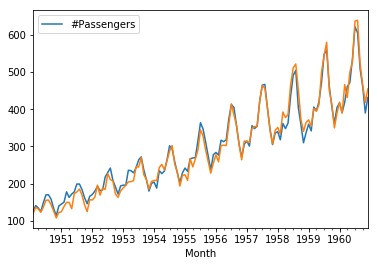

In [38]:
order = scores[0][0][0]
sorder = scores[0][0][1]
trend = scores[0][0][2]

model = SARIMAX(ts_noincreasingvar, order=order, seasonal_order=sorder, trend=trend)
model_fit = model.fit(disp=0)
predsarima = np.exp(model_fit.predict(sorder[-1]+1,dynamic=False))

ax = np.exp(ts_noincreasingvar[sorder[-1]+1:]).plot(label='observed')
predsarima.plot(label='One-step ahead Forecast', ax=ax)
plt.show()

We have detected the trend and seasonality almost perfectly!!!

We can also compute other measures of quality apart from RMSE (and even guide the parameter tuning with these measures):

In [39]:
def forecast_accuracy(actual, forecast):
    actual = np.squeeze(actual)
    forecast = np.squeeze(forecast)
    mse = mean_squared_error(actual, forecast)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE                     
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'mse': mse})

print('ARIMA')
stats = forecast_accuracy(np.exp(ts_noincreasingvar[sorder[-1]+1:].values), predarima.values)
for key in stats.keys():
    print(key,': \t',stats[key])

print('SARIMA')
stats = forecast_accuracy(np.exp(ts_noincreasingvar[sorder[-1]+1:].values), predsarima.values)
for key in stats.keys():
    print(key,': \t',stats[key])

ARIMA
mape : 	 0.08124235556147369
me : 	 -1.6219541474877281
mae : 	 24.104461445850088
mpe : 	 -0.00138402547482269
rmse : 	 29.56793952769136
mse : 	 874.2630479132133
SARIMA
mape : 	 0.05124427374246154
me : 	 -2.7283999934355623
mae : 	 13.506225574737927
mpe : 	 -0.021322375695832792
rmse : 	 17.00474716753212
mse : 	 289.1614262316916


Can you do even better? Good luck!